<html>
<div>
  <span style="font-family: Poppins; font-size:30px; color: black;"> <br/> University of Tehran <br/>
</div>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> Mobina Mehrazar </span><br>
<span style="font-family: Poppins; font-size:15pt; color: black; vertical-align: middle;"> 810100216 </span>

</html>

# Harmonizing Melodies: A Hidden Markov Model Approach to Music Genre Classification

This report presents a novel approach to music genre classification using Hidden Markov Models (HMMs). 

Our study focuses on four distinct music genres: blues, pop, metal, and hip-hop. We preprocess a dataset of .wav files, each approximately 30 seconds in length, by removing the initial empty part of each file. The crux of our approach lies in the application of a first-order HMM, where each genre is considered a 'state' and the features extracted from the .wav files are the 'observations'. 

The report delves into the intricacies of HMMs, discussing their advantages, disadvantages, and suitability for our problem. We also explore various types of HMMs and their potential applications in our context.

Through this project, we aim to demonstrate the efficacy of HMMs in music genre classification and provide insights that could be beneficial for future research in this domain.

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from scipy.stats import multivariate_normal
from hmmlearn import hmm
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pydub import AudioSegment

/home/mehdi/anaconda3/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


2. **Types of HMM Models:**
- Left-Right HMM: Restricts the state transitions to progress from left to right, preventing self-loops.
- Continuous HMM (CHMM): Allows observations to be continuous, often used in speech recognition.
- Ergodic HMM: Permits any state transition to any other state, providing more flexibility in modeling transitions.
- Duration HMM: Introduces state duration modeling to capture varying time lengths spent in each state.
- Input-Output HMM: Allows explicit modeling of input and output sequences, suitable for certain control system applications.

In [4]:
segment_duration = 28000

def split_audio_into_segments(input_path, output_folder, segment_duration):
    audio = AudioSegment.from_wav(input_path)
    num_segments = len(audio) // segment_duration

    for i in range(num_segments):
        start_time = i * segment_duration
        end_time = start_time + segment_duration
        segment = audio[start_time:end_time]
        
        output_filename = f"{os.path.splitext(os.path.basename(input_path))[0]}.wav"
        output_path = os.path.join(output_folder, output_filename)
        segment.export(output_path, format="wav")

for subdir_name in os.listdir('data'):
    dir_path = os.path.join('data', subdir_name)
    
    for file_name in os.listdir(dir_path):
        audio_path = os.path.join(dir_path, file_name)
        split_audio_into_segments(audio_path, dir_path, segment_duration)

This is all music genres we have

In [6]:
for file in os.listdir('data/'):
    print(file)

hiphop
pop
metal
blues


Question 1

having samples of the same length can simplify the model, improve performance, and ensure that features are computed correctly. It’s a common requirement in many machine learning and signal processing tasks.

In [7]:
def feature_extraction(audio_path, t=0):
    (xf, sr) = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=13)
    if t == 1:
        mfccs = mfccs.T
    return mfccs

def plot_mfcc(mfccs, audio_name):
    librosa.display.specshow(mfccs, x_axis="time")
    plt.colorbar()
    plt.tight_layout()
    plt.title(f"MFCC Of {audio_name}")
    plt.ylabel("MFCC Coefficients")
    plt.show()

In [8]:
def plot_confusion_matrix(conf_matrix):
    matrix = [[conf_matrix[genre1][genre2] for genre2 in conf_matrix[genre1]] for genre1 in conf_matrix]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=conf_matrix.keys(), yticklabels=conf_matrix.keys())
    plt.xlabel('Predicted Genre')
    plt.ylabel('True Genre')
    plt.title('Confusion Matrix')
    plt.show()
    
def calculate_micro_average(confusion_data):
    total_true_positive = sum(confusion_data[class_name][class_name] for class_name in confusion_data.keys())
    total_false_positive = sum(confusion_data[key][class_name] for class_name in confusion_data.keys() for key in confusion_data.keys() if key != class_name)
    total_false_negative = sum(confusion_data[class_name][key] for class_name in confusion_data.keys() for key in confusion_data.keys() if key != class_name)
    
    micro_precision = total_true_positive / (total_true_positive + total_false_positive) if total_true_positive + total_false_positive != 0 else 0
    micro_recall = total_true_positive / (total_true_positive + total_false_negative) if total_true_positive + total_false_negative != 0 else 0
    
    if micro_precision + micro_recall == 0:
        micro_f1_score = 0
    else:
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    
    return micro_f1_score

MFCC coefficients contain information about the rate changes in the different spectrum bands.

In [9]:
def heatmap_plot(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sortedlabels = ["Blues", "HipHop", "Metal", "Pop"]
    cm = pd.DataFrame(cm, index=[sortedlabels], columns=sortedlabels)
    plt.figure(figsize = (10,5))
    sns.heatmap(cm, linewidths=0.5, annot=True, cmap="Blues", fmt='g')
    plt.title("Confusiuon Matrix Heatmap for "+title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [10]:
def train_hmm_model(training_set, num_hidden_states=4):
    model = hmm.GaussianHMM(n_components=num_hidden_states)
    # model = hmm.GaussianHMM(n_components=num_hidden_states, covariance_type='diag', n_iter=100)
    train_set = np.concatenate(training_set)
    model.fit(train_set)
    return model

def evaluate_model(model, x_test):
    return model.score(x_test)

In [15]:
def process_genre(label, t):
    features = []
    labels = np.empty(0, dtype=str) 
    directory = os.path.join('data', label)

    for i, audio in enumerate(os.listdir(directory)):
        audio_path = os.path.join(directory, audio)
        labels = np.concatenate((labels, [label]), axis=0)

        mfccCoeffs = feature_extraction(audio_path, t)
        features.append(mfccCoeffs)

    plot_mfcc(features[i], audio)
    features = np.array(features)

    return features

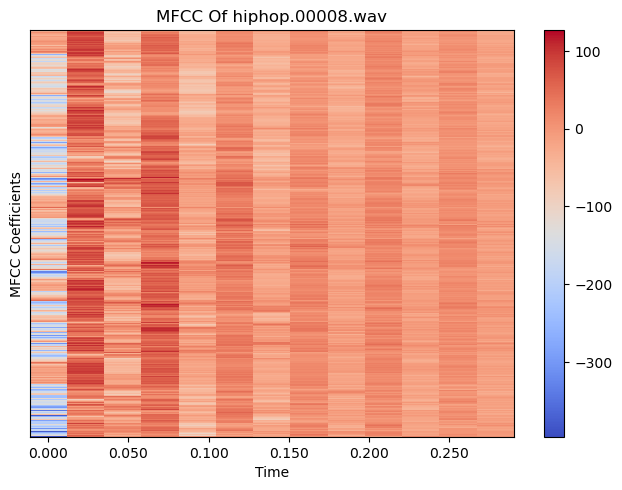

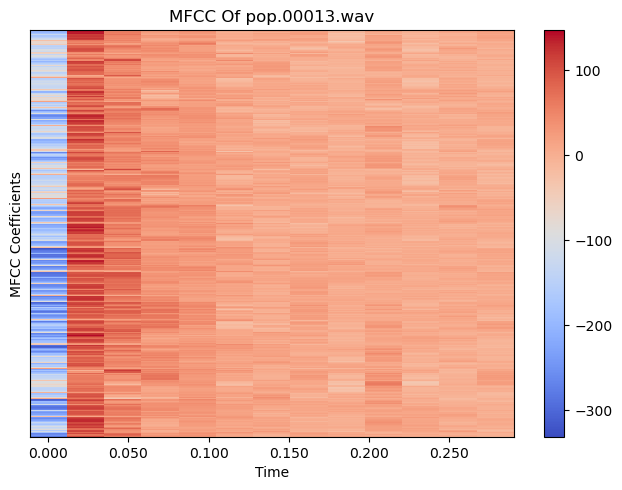

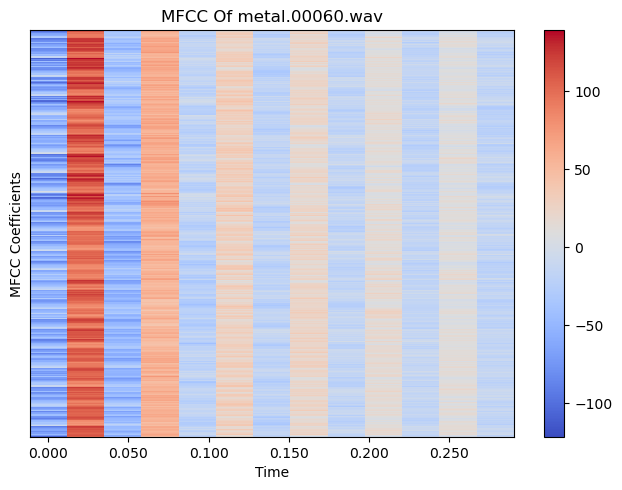

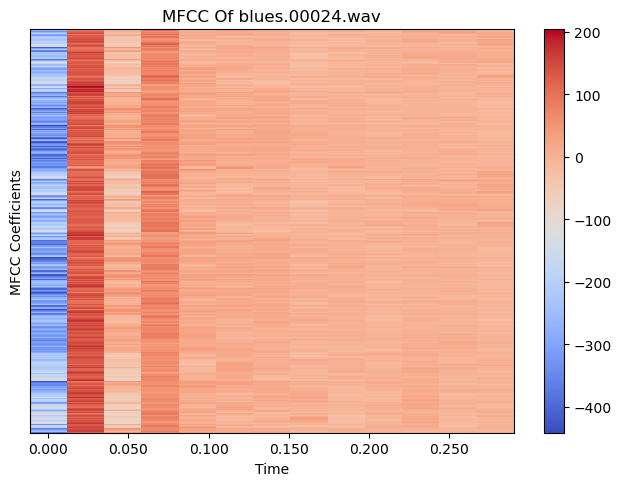

In [16]:
X_train = {}
X_test = {}

for i, dir_name in enumerate(os.listdir('data')):
    features = process_genre(dir_name, 1)
    x_train, x_test, _, _ = train_test_split(features, features, test_size=0.2, random_state=1) 

    X_train[dir_name] = {'features': x_train}
    X_test[dir_name] = {'features': x_test}

In [17]:
models = {}
for music_genre in os.listdir('data/'):
    hmm_model = train_hmm_model(X_train[music_genre]['features'], 13)
    models[music_genre] = hmm_model

In [18]:
confusion_data = {'blues':  {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0},
                  'hiphop': {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0},
                  'metal':  {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0},
                  'pop':    {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0}
                 }

genres = ['blues', 'hiphop', 'metal', 'pop']

y_true, y_pred = [], []
for music_genre in os.listdir('data/'):
    size = X_test[music_genre]['features'].shape[0]

    for i in range(size):
        s1 = (evaluate_model(models['blues'], X_test[music_genre]['features'][i]))
        s2 = (evaluate_model(models['hiphop'], X_test[music_genre]['features'][i]))
        s3 = (evaluate_model(models['metal'], X_test[music_genre]['features'][i]))
        s4 = (evaluate_model(models['pop'], X_test[music_genre]['features'][i]))
        result = [s1, s2, s3, s4]
        max_index = result.index(max(result))
        predicted = genres[max_index]
        confusion_data[music_genre][predicted] += 1
        y_true.append(music_genre)
        y_pred.append(predicted)

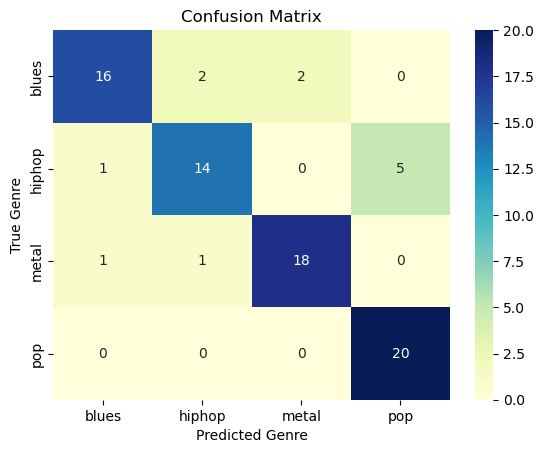

              precision    recall  f1-score   support

       blues       0.89      0.80      0.84        20
      hiphop       0.82      0.70      0.76        20
       metal       0.90      0.90      0.90        20
         pop       0.80      1.00      0.89        20

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80

micro average for precision: 0.85
micro average for recall: 0.85
micro average for f1 score: 0.85


In [19]:
plot_confusion_matrix(confusion_data)
print(classification_report(y_true, y_pred))
print(f"micro average for precision: {calculate_micro_average(confusion_data)}")
print(f"micro average for recall: {calculate_micro_average(confusion_data)}")
print(f"micro average for f1 score: {calculate_micro_average(confusion_data)}")

2.In the calculation of MFCCs, the frames used do overlap with each other. This is done to ensure continuity between frames and to prevent loss of information at the boundaries of the frames. The amount of overlap can vary, but a common choice is to have a 50% overlap between successive frames. This means that the start of each frame is halfway through the previous frame. This overlapping technique is known as windowing and is a common practice in signal processing.

3.The initial coefficients (usually the first 12 or 13) contain the most information about the sound and represent the envelope or timbre of the sound. The higher coefficients contain more details about the sound that may be useful for some applications, but in many cases, these details may introduce noise or unnecessary complexity. Therefore, in many projects, only the first 12 or 13 MFCC coefficients are used.

In [23]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = self.initial_prob.flatten() * observation_matrix[:, t]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)
        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T, mean=self.mean[:, s], cov=self.covariances[:, :, s])
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))
        
        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],beta[:,t+1].T)*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        gamma[:, t] = self._normalize(gamma[:, t])

        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:,0]
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


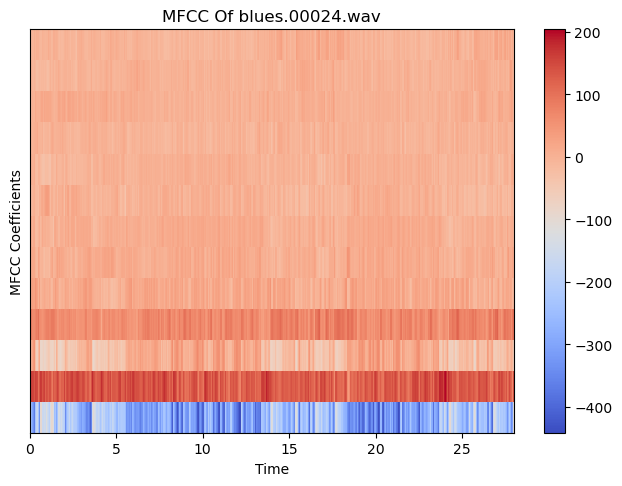

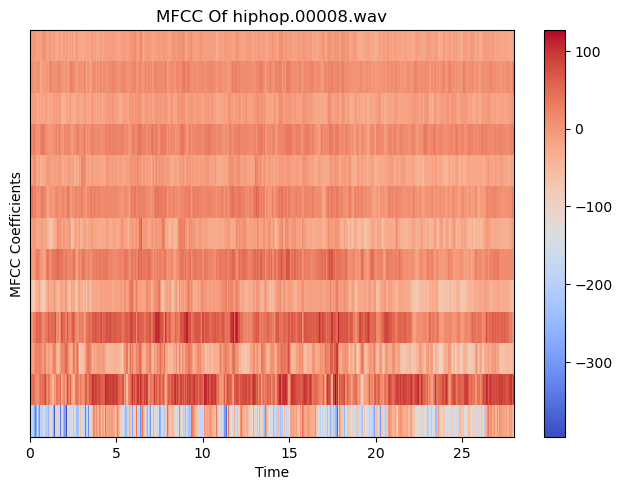

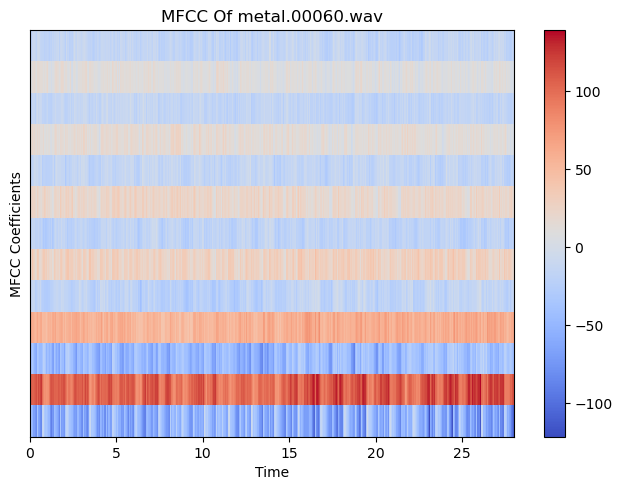

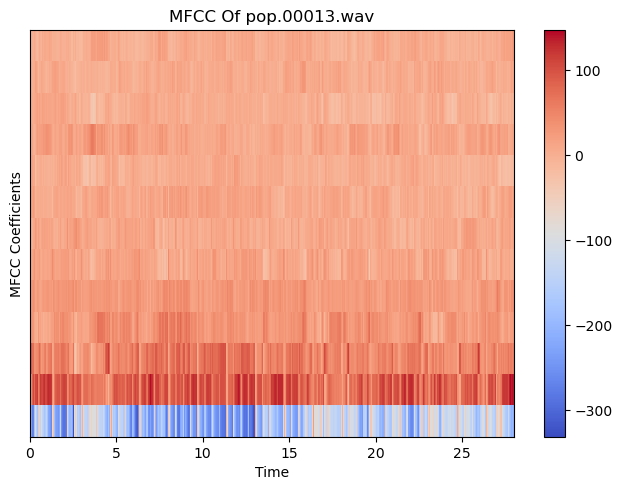

In [21]:
X_train = {}
X_test = {}

genres_folders = ['blues', 'hiphop', 'metal', 'pop']

for i, dir_name in enumerate(genres_folders):
    features_ = process_genre(dir_name, 0)
    x_train, x_test = train_test_split(features_, test_size=0.2, random_state=1) 

    X_train[dir_name] = {'features': x_train}
    X_test[dir_name] = {'features': x_test}

In [26]:
hmm_models_ = []

genres_folders = ['blues', 'hiphop', 'metal', 'pop']

# print(os.listdir('dataset'))

for i in enumerate(genres_folders):
    print(i[1])
    size = X_train[i[1]]['features'].shape[0]
    genre_hmm = HMM(3)
    for j in range(size):
        train_set = X_train[i[1]]['features'][j] / np.amax(X_train[i[1]]['features'][j]) 
        genre_hmm.train(train_set, 3)
    hmm_models_.append(genre_hmm)

blues
hiphop
metal
pop


In [27]:
confusion_data2 = {'blues':  {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0},
                  'hiphop': {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0},
                  'metal':  {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0},
                  'pop':    {'blues': 0, 'hiphop': 0, 'metal': 0, 'pop': 0}
                 }

genres = ['blues', 'hiphop', 'metal', 'pop']
genres_folders = ['blues', 'hiphop', 'metal', 'pop']

y_true, y_pred = [], []
for i, dir_name in enumerate(genres_folders):
# for i, dir_name in enumerate(os.listdir('dataset')):
    for j in range(size):
        train_set2 = X_train[dir_name]['features'][j] / np.amax(X_train[dir_name]['features'][j])
        res = []
        for model in hmm_models_:
            size = X_test[dir_name]['features'].shape[0]
            res.append(model.score(train_set2))

        max_index = res.index(max(res))
        predicted = genres[max_index]
        confusion_data2[dir_name][predicted] += 1
        y_true.append(dir_name)
        y_pred.append(predicted)

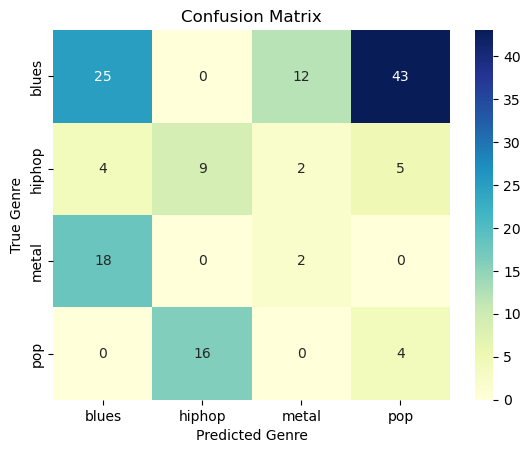

              precision    recall  f1-score   support

       blues       0.53      0.31      0.39        80
      hiphop       0.36      0.45      0.40        20
       metal       0.12      0.10      0.11        20
         pop       0.08      0.20      0.11        20

    accuracy                           0.29       140
   macro avg       0.27      0.27      0.25       140
weighted avg       0.38      0.29      0.31       140

micro average for precision: 0.2857142857142857
micro average for recall: 0.2857142857142857
micro average for f1 score: 0.2857142857142857


In [28]:
plot_confusion_matrix(confusion_data2)
print(classification_report(y_true, y_pred))
print(f"micro average for precision: {calculate_micro_average(confusion_data2)}")
print(f"micro average for recall: {calculate_micro_average(confusion_data2)}")
print(f"micro average for f1 score: {calculate_micro_average(confusion_data2)}")

************************************************************************

1. **Why is it necessary for the samples to have the same length?**
- Having samples of the same length ensures that the input data fed into the model is consistent, making it easier to design and train the model.
- Processing fixed-size samples is computationally more efficient. It allows for batch processing, and the model can be optimized to handle a specific input size, leading to better performance.
2. **Why do the frames overlap with each other in the calculation of MFCC?**
- Overlapping frames help capture temporal dependencies and variations in the audio signal. Music and speech often contain time-varying characteristics that might not be well-represented in isolated frames.
- Overlapping frames provide a smooth transition between consecutive frames, reducing the risk of information loss at the frame boundaries. This is especially important in capturing nuances in the audio signal.
- Overlapping frames can help mitigate the effects of temporal aliasing, ensuring that important information is not missed during the frame-by-frame analysis.
- Overlapping frames contribute to the robustness of feature extraction, making the system less sensitive to small temporal shifts or variations in the input signal.
3. **Why are only the initial 12 or 13 MFCC coefficients typically used in most audio-related projects?**
- The initial coefficients capture the most significant information about the audio signal. Using all coefficients might lead to high-dimensional feature vectors, which could increase computational complexity and the risk of overfitting, especially when dealing with limited data.
- The human auditory system is often more sensitive to certain frequency ranges. The initial MFCC coefficients are designed to mimic the human ear's sensitivity to different frequency bands, providing a compact representation of the audio signal that retains important perceptual information.
- Over time, researchers have found that using a relatively small number of initial MFCC coefficients is effective for various audio classification tasks.
- Using a reduced set of coefficients improves computational efficiency during both training and inference without significantly sacrificing the model's performance for many audio classification tasks.

************************************************************************

1. **States and Observations in HMM:**
- States: In HMM, states represent the underlying, unobservable system that transitions over time. Each state corresponds to a certain situation or condition of the system. Transitions between states are governed by probabilities.
- Observations: Observations are the visible outputs or measurements that are associated with each state. These are the data points that can be directly observed.

In the context of music genre classification using HMM, the states might represent different musical characteristics or styles, and observations could be features extracted from the audio data, such as MFCC coefficients.

2. **First-Order HMM:**
First-Order HMM is a specific type of Hidden Markov Model where the current state is directly dependent only on the immediately preceding state.
- Nomenclature and Features:
  
First-Order Markov Model: The term "First-Order" signifies that the model follows the first-order Markov property. This property states that the probability of transitioning to a particular state depends solely on the current state and not on the sequence of events that preceded it.

Transition Dependency: In a First-Order HMM, the transition probabilities are conditioned only on the current state. Mathematically, the probability of transitioning to a state jj from the current state ii is denoted as \(P(q_{t+1}=j | q_t=i)\), where \(q_t\) represents the hidden state at time \(t\).


Simple Dependency Structure: The simplicity of the model lies in its assumption that the current state captures all relevant information for predicting the next state. This results in a more straightforward model with fewer parameters compared to higher-order HMMs.
- Differences from Other Models:

Higher-Order HMMs: In contrast to First-Order HMMs, higher-order HMMs consider dependencies beyond just the immediate preceding state. For example, a Second-Order HMM considers transitions depending on the current state and the state before it. This can capture more complex dependencies in the sequence of hidden states.

Lower Complexity: First-Order HMMs are computationally less demanding compared to higher-order models. The simplicity in the dependency structure contributes to easier model training and inference.

Assumption of Markovian Property: The First-Order HMM assumes that the system being modeled exhibits a Markovian property, meaning that the future state depends only on the present state and is independent of the past states given the present. This assumption may be appropriate for certain applications where the Markov property holds.

Applications: First-Order HMMs are commonly employed in various fields such as speech recognition, where the assumption of short-term dependencies is reasonable, and the computational efficiency of a first-order model is advantageous.

3. **Suitability of HMM:**

Hidden Markov Models (HMMs) are probabilistic models that are particularly well-suited for analyzing and modeling phenomena characterized by sequential data and underlying hidden states. They have found applications in various fields due to their ability to capture temporal dependencies and latent structures in dynamic systems. 

Speech Recognition:

HMMs are widely employed in speech recognition systems. The speech signal is modeled as a sequence of hidden states, and each state emits observable features. HMMs can effectively model the variability in speech patterns and account for the temporal nature of spoken language.

Bioinformatics:

In bioinformatics, HMMs are utilized for tasks such as gene prediction, sequence alignment, and protein structure prediction. They can model biological sequences as sequences of hidden states and capture dependencies between adjacent elements.

Natural Language Processing (NLP):

HMMs are employed in NLP for various tasks, including part-of-speech tagging and named entity recognition. Words in a sentence are treated as observable emissions, and underlying grammatical structures are represented by hidden states.

Financial Time Series Analysis:

HMMs are used in finance to model and analyze time series data, such as stock prices. The hidden states may represent different market regimes, and observable emissions are the financial indicators.

Robotics and Control Systems:

HMMs find applications in modeling dynamic systems in robotics and control. They can represent the hidden states of a system's behavior, allowing for effective control and decision-making in real-time.

Fault Detection and Diagnosis:

In engineering, HMMs are applied to detect and diagnose faults in complex systems. The hidden states represent the health conditions of the system, and observable emissions are sensor readings.

The rationale behind using HMMs lies in their capability to model sequential data and capture the inherent dynamics of a system. By representing the system as a sequence of hidden states and observable emissions, HMMs provide a flexible framework for modeling complex relationships and dependencies over time. Their ability to handle uncertainty and variability in sequential data makes them a valuable tool in diverse fields where understanding temporal patterns and hidden structures is crucial for analysis and prediction.

4. **Pros and Cons of HMM:**
- Pros:
###### Effectively models sequential data with underlying hidden states.
###### Suitable for systems with dynamic and time-dependent behavior.
###### Well-established and widely used in various applications.
- Cons:
###### Assumes independence between observations given the hidden state.
###### Sensitivity to model parameters and initialization.
###### Complexity increases with the number of states, affecting computational efficiency.

5. **Types of HMM Models:**
- Left-Right HMM: Restricts the state transitions to progress from left to right, preventing self-loops.
- Continuous HMM (CHMM): Allows observations to be continuous, often used in speech recognition.
- Ergodic HMM: Permits any state transition to any other state, providing more flexibility in modeling transitions.
- Duration HMM: Introduces state duration modeling to capture varying time lengths spent in each state.
- Input-Output HMM: Allows explicit modeling of input and output sequences, suitable for certain control system applications.

************************************************************************************************************************************

1.

#### PRECISION
It is define as the actual correct prediction divided by total prediction made by model.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Precision</mtext><mo>=</mo><mfrac><mrow><mi>T</mi><mi>P</mi></mrow><mrow><mi>T</mi><mi>P</mi><mo>+</mo><mi>F</mi><mi>P</mi></mrow></mfrac></mrow><annotation encoding="application/x-tex">\text{Precision} = \frac{TP}{TP + FP}
</annotation></semantics></math>
where:
- TP stands for True Positives, which are the correctly predicted positive values.
- FP stands for False Positives, which are the incorrectly predicted positive values.
#### RECALL
In an classification problem with two classes, recall is calculated as the number of true positives divided by the total number of true positives and false negatives.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Recall</mtext><mo>=</mo><mfrac><mrow><mi>T</mi><mi>P</mi></mrow><mrow><mi>T</mi><mi>P</mi><mo>+</mo><mi>F</mi><mi>N</mi></mrow></mfrac></mrow><annotation encoding="application/x-tex">\text{Recall} = \frac{TP}{TP + FN}
</annotation></semantics></math>
where:
- TP stands for True Positives.
- FN stands for False Negatives, which are the incorrectly predicted negative values.
#### ACCURACY
It is defined as total correctly classified example divided by the total number of classified examples(once for all classes).
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>Accuracy</mtext><mo>=</mo><mfrac><mrow><mi>T</mi><mi>P</mi><mo>+</mo><mi>T</mi><mi>N</mi></mrow><mrow><mi>T</mi><mi>P</mi><mo>+</mo><mi>T</mi><mi>N</mi><mo>+</mo><mi>F</mi><mi>P</mi><mo>+</mo><mi>F</mi><mi>N</mi></mrow></mfrac></mrow><annotation encoding="application/x-tex">\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
</annotation></semantics></math>
where:
- TP stands for True Positives.
- TN stands for True Negatives, which are the correctly predicted negative values.
- FP stands for False Positives.
- FN stands for False Negatives.
#### F1 SCORE
F1 score is a weighted average of precision and recall. As we know in precision and in recall there is false positive and false negative so it also consider both of them.
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>F1&nbsp;Score</mtext><mo>=</mo><mn>2</mn><mo>×</mo><mfrac><mrow><mtext>Recall</mtext><mo>×</mo><mtext>Precision</mtext></mrow><mrow><mtext>Recall</mtext><mo>+</mo><mtext>Precision</mtext></mrow></mfrac></mrow><annotation encoding="application/x-tex">\text{F1 Score} = 2 \times \frac{\text{Recall} \times \text{Precision}}{\text{Recall} + \text{Precision}}
</annotation></semantics></math>


2.

The F1 score is not calculated using a traditional averaging method like mean or median. Instead, it is derived from precision and recall, which are metrics commonly used in binary classification problems. The F1 score is the harmonic mean of precision and recall.

It is used to balance precision and recall, providing a single metric that considers both false positives and false negatives in a binary classification task.

F1 score is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

Why are Recall and Precision not sufficient alone for model evaluation?

Recall: A high recall indicates that the model is effective in capturing most of the positive instances; however, it may result in a higher number of false positives, which can be costly in certain applications.

Precision: High precision implies that the model is accurate in identifying positive instances, but it might miss some relevant instances, leading to a lower recall.

Example:

Consider a medical diagnostic model designed to identify patients with a rare disease. Let's say the prevalence of the disease is very low, and only 1 out of 1,000 individuals has the disease.

The model predicts 10 individuals as positive cases.
Out of these 10, only 1 individual actually has the disease (True Positive), while the other 9 are false positives.
The model correctly identifies the one positive case, resulting in high precision (1/10 = 0.1), but the recall is extremely low (1/1 = 1).

In this example, although precision is high, the model is not effectively capturing all the positive cases, and the low recall indicates that it may not be suitable for practical use. This illustrates why considering both recall and precision together, often in the form of the F1 score or the Receiver Operating Characteristic (ROC) curve, provides a more comprehensive evaluation of the model's performance.


3.

The "F1 score" uses a type of averaging known as the harmonic mean. The harmonic mean differs from the typical arithmetic mean, and its significance lies in how it handles extreme values.

The harmonic mean is calculated as the reciprocal of the arithmetic mean of the reciprocals of a set of values. For a set of values x1,x2,...,xnx1​,x2​,...,xn​, the harmonic mean (H) is given by:

H=n1x1+1x2+...+1xnH=x1​1​+x2​1​+...+xn​1​n​

In contrast to the arithmetic mean, the harmonic mean gives more weight to smaller values. This characteristic makes it particularly suitable for situations where one extreme value (such as a low recall or precision) significantly influences the overall metric.

The F1 score is the harmonic mean of precision and recall, combining both metrics into a single value. It is defined as:

F1=2×Precision×RecallPrecision+RecallF1=2×Precision+RecallPrecision×Recall​

The use of the harmonic mean in the F1 score is important because it ensures a balanced consideration of precision and recall. In cases where one of these metrics is much lower than the other, the harmonic mean penalizes the overall score, providing a more accurate reflection of the model's performance, especially in imbalanced datasets or situations where both precision and recall need to be emphasized equally.

4.

Macro-Averaging:
    In macro-averaging, performance metrics are calculated independently for each class, and then the average is taken across all classes. It treats all classes equally, regardless of their size or imbalance.
    For example, in macro-averaged precision, recall, and F1 score, each class contributes equally to the final average, irrespective of the class's prevalence in the dataset.


$$Macro Recall = \frac{1}{N} \sum_{i=1}^{N} Recall_i$$

Micro-Averaging:
    Micro-averaging involves aggregating the contributions of all classes by considering the total number of true positives, false positives, and false negatives across all classes.
    In micro-averaging, each instance contributes equally to the final aggregated metric, regardless of its class. It is particularly useful when dealing with imbalanced datasets, as it considers the overall performance on a per-instance basis.

$$Micro Recall = \frac{\sum_{i=1}^{N} TruePositives_i}{\sum_{i=1}^{N} (TruePositives_i + FalseNegatives_i)}$$

Weighted-Averaging:
    Weighted-averaging assigns a weight to each class based on its proportion in the dataset. Classes with more instances have a greater impact on the final average.
    This method is valuable when there is class imbalance, as it gives more importance to the metrics of classes with larger representations. It provides a balanced performance measure that considers both overall and class-specific contributions.

$$Weighted Recall = \frac{1}{\sum_{i=1}^{N} NumInstances_i} \sum_{i=1}^{N} (NumInstances_i \times Recall_i)$$


These averaging methods offer different perspectives on the model's performance in multi-class classification scenarios. The choice of averaging method depends on the specific characteristics of the dataset and the goals of the evaluation. Researchers and practitioners often consider multiple averaging methods to gain a comprehensive understanding of the model's effectiveness across different aspects of the classification task.

5.



6.

In part one while using python libraries to train and test, precision and recall was higher than the one calculated in part 2. Also they were more close to each other.
This means the first calculation had a better performance that the other part.
In part two precision in blues is 1 and recals is very low.
The prediction is mostly hiphop and as we can see the heatmap for the coefficient of these two are somehow similar to each other.

7.



The library model has the flexibility to employ various Hidden Markov Model (HMM) structures or engage in hyperparameter optimization to enhance its performance. Additionally, it is capable of executing more intricate algorithms with efficiency. The critical aspect lies in how the library model translates observations into the B matrix.